In [39]:
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)
sns.set_theme(style="whitegrid", context="talk")

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    DATA_DIR = Path("../data")
DATA_DIR


WindowsPath('../data')

In [40]:
po_cols = [
    "po_id",
    "supplier_id",
    "sku_id",
    "order_qty",
    "unit_price_usd",
    "order_date",
    "promised_date",
    "region",
    "country",
    "status",
]
purchase_orders = pd.read_csv(
    DATA_DIR / "purchase_orders.csv",
    usecols=po_cols,
    parse_dates=["order_date", "promised_date"],
)

shipments = pd.read_csv(
    DATA_DIR / "shipments.csv",
    parse_dates=["ship_date", "eta_date"],
)

transit_events = pd.read_csv(
    DATA_DIR / "transit_events.csv",
    parse_dates=["event_ts"],
)

suppliers = pd.read_csv(DATA_DIR / "suppliers.csv")
skus = pd.read_csv(DATA_DIR / "skus.csv")
sites = pd.read_csv(DATA_DIR / "sites.csv")

print(
    f"Loaded {len(purchase_orders):,} POs, {len(shipments):,} shipments, and {len(transit_events):,} transit events."
)


Loaded 150,000 POs, 217,500 shipments, and 400,000 transit events.


In [41]:
summaries = []
for name, df in {
    "purchase_orders": purchase_orders,
    "shipments": shipments,
    "transit_events": transit_events,
    "suppliers": suppliers,
    "skus": skus,
    "sites": sites,
}.items():
    summaries.append(
        {
            "dataset": name,
            "rows": len(df),
            "columns": df.shape[1],
            "null_pct": (df.isna().sum().sum() / (df.shape[0] * df.shape[1])).round(4),
        }
    )

pd.DataFrame(summaries)


,dataset,rows,columns,null_pct
0,purchase_orders,150000,10,0.0000
1,shipments,217500,10,0.0000
2,transit_events,400000,4,0.0000
3,suppliers,200,6,0.0000
4,skus,5000,8,0.0000
5,sites,2000,7,0.0501


In [42]:
delivered_counts = (
    transit_events[transit_events["event_status"] == "Delivered"]
    .groupby("shipment_id")
    .size()
)
print(f"{(delivered_counts > 1).sum():,} shipments have multiple Delivered events.")

7,749 shipments have multiple Delivered events.


In [ ]:
delivered_events = (
    transit_events.loc[transit_events["event_status"] == "Delivered", ["shipment_id", "event_ts"]]
    .sort_values(["shipment_id", "event_ts"])
)
delivered_events = (
    transit_events.loc[transit_events["event_status"] == "Delivered",
                        ["shipment_id", "event_ts"]]
    .sort_values(["shipment_id", "event_ts"])
)

actual_deliveries = (
    delivered_events
    .drop_duplicates(subset="shipment_id", keep="last")
    .rename(columns={"event_ts": "actual_delivery_ts"})
)

print(f"Identified {len(actual_deliveries):,} shipments with a delivered timestamp.")
actual_deliveries

Identified 55,232 shipments with a delivered timestamp.


,shipment_id,actual_delivery_ts
377575,SH-00000004,2025-09-02 20:00:00
163891,SH-00000007,2024-02-29 03:00:00
39461,SH-00000011,2023-04-13 01:00:00
86263,SH-00000012,2023-08-12 04:00:00
243478,SH-00000013,2024-09-20 15:00:00
...,...,...
295356,SH-00217482,2025-02-01 19:00:00
129353,SH-00217483,2023-12-02 04:00:00
365969,SH-00217486,2025-08-03 19:00:00
335222,SH-00217492,2025-05-16 08:00:00


In [44]:
shipments_enriched = (
    shipments.merge(actual_deliveries, on="shipment_id", how="inner")
    .assign(
        actual_delivery_ts=lambda df: pd.to_datetime(df["actual_delivery_ts"]),
        actual_transit_days=lambda df: (df["actual_delivery_ts"] - df["ship_date"]).dt.days,
        planned_transit_days=lambda df: (df["eta_date"] - df["ship_date"]).dt.days,
    )
)

po_shipments = shipments_enriched.merge(
    purchase_orders,
    on="po_id",
    how="inner",
    suffixes=("_ship", "_po"),
)

po_shipments["actual_lead_time_days"] = (
    (po_shipments["actual_delivery_ts"] - po_shipments["order_date"]).dt.days
)
po_shipments["promised_lead_time_days"] = (
    (po_shipments["promised_date"] - po_shipments["order_date"]).dt.days
)
po_shipments["ship_lag_from_order_days"] = (
    (po_shipments["ship_date"] - po_shipments["order_date"]).dt.days
)
po_shipments["value_usd"] = po_shipments["order_qty"] * po_shipments["unit_price_usd"]
po_shipments["eta_slip_days"] = (
    (po_shipments["actual_delivery_ts"] - po_shipments["eta_date"]).dt.days
)

print(f"Merged dataset rows: {len(po_shipments):,}")


Merged dataset rows: 55,232


In [45]:
supplier_cols = suppliers.rename(
    columns={
        "region": "supplier_region",
        "country": "supplier_country",
        "primary_vendor": "supplier_primary_vendor",
        "on_time_performance": "supplier_on_time_performance",
        "iso_certified": "supplier_iso_certified",
    }
)
po_shipments = po_shipments.merge(supplier_cols, on="supplier_id", how="left")

sku_cols = skus[[
    "sku_id",
    "category",
    "technology",
    "supplier_nominal_lead_time_days",
]].rename(
    columns={
        "category": "sku_category",
        "technology": "sku_technology",
        "supplier_nominal_lead_time_days": "sku_nominal_lead_time_days",
    }
)
po_shipments = po_shipments.merge(sku_cols, on="sku_id", how="left")

site_cols = sites.rename(
    columns={
        "site_id": "dest_site_id",
        "region": "dest_region",
        "country": "dest_country",
        "site_type": "dest_site_type",
        "operator": "dest_operator",
    }
)[["dest_site_id", "dest_region", "dest_country", "dest_site_type", "dest_operator"]]
po_shipments = po_shipments.merge(site_cols, on="dest_site_id", how="left")

print(f"Dataset after enrichment: {len(po_shipments):,} rows, {po_shipments.shape[1]} columns")


Dataset after enrichment: 55,232 rows, 39 columns


In [46]:
model_df = po_shipments.copy()
initial_rows = len(model_df)

valid_mask = (
    (model_df["actual_lead_time_days"] >= 0)
    & (model_df["ship_lag_from_order_days"] >= 0)
    & (model_df["actual_transit_days"] >= 0)
)
model_df = model_df.loc[valid_mask].copy()

model_df = model_df.loc[model_df["promised_lead_time_days"] >= 0]

upper_cap = model_df["actual_lead_time_days"].quantile(0.99)
model_df = model_df.loc[model_df["actual_lead_time_days"] <= upper_cap]

print(
    f"Filtered out {initial_rows - len(model_df):,} rows ({(1 - len(model_df)/initial_rows):.1%}) due to invalid or extreme lead times."
)
model_df["actual_lead_time_days"].describe()


Filtered out 45,396 rows (82.2%) due to invalid or extreme lead times.


count    9836.000000
mean      520.081741
std       225.807313
min         4.000000
25%       343.750000
50%       526.000000
75%       697.000000
max       972.000000
Name: actual_lead_time_days, dtype: float64

In [47]:
corr_cols = [
    "actual_lead_time_days",
    "promised_lead_time_days",
    "ship_lag_from_order_days",
    "actual_transit_days",
    "planned_transit_days",
    "eta_slip_days",
    "value_usd",
    "order_qty",
    "ship_qty",
    "unit_price_usd",
    "sku_nominal_lead_time_days",
    "supplier_on_time_performance",
]

corr_matrix = model_df[corr_cols].corr().round(2)
corr_matrix


,actual_lead_time_days,promised_lead_time_days,ship_lag_from_order_days,actual_transit_days,planned_transit_days,eta_slip_days,value_usd,order_qty,ship_qty,unit_price_usd,sku_nominal_lead_time_days,supplier_on_time_performance
actual_lead_time_days,1.00,0.02,0.57,0.56,-0.01,0.56,0.01,0.01,0.00,0.00,0.01,0.02
promised_lead_time_days,0.02,1.00,-0.00,0.02,-0.00,0.02,0.01,0.01,-0.01,0.00,-0.01,-0.00
ship_lag_from_order_days,0.57,-0.00,1.00,-0.36,-0.00,-0.36,0.00,0.03,-0.01,-0.01,0.01,0.00
actual_transit_days,0.56,0.02,-0.36,1.00,-0.01,1.00,0.01,-0.01,0.01,0.01,0.00,0.02
planned_transit_days,-0.01,-0.00,-0.00,-0.01,1.00,-0.07,-0.00,0.01,-0.00,-0.00,0.00,0.01
eta_slip_days,0.56,0.02,-0.36,1.00,-0.07,1.00,0.01,-0.01,0.01,0.01,0.00,0.02
value_usd,0.01,0.01,0.00,0.01,-0.00,0.01,1.00,0.31,0.02,0.91,-0.01,-0.02
order_qty,0.01,0.01,0.03,-0.01,0.01,-0.01,0.31,1.00,0.01,0.01,-0.00,-0.02
ship_qty,0.00,-0.01,-0.01,0.01,-0.00,0.01,0.02,0.01,1.00,0.01,0.03,0.01
unit_price_usd,0.00,0.00,-0.01,0.01,-0.00,0.01,0.91,0.01,0.01,1.00,-0.00,-0.01


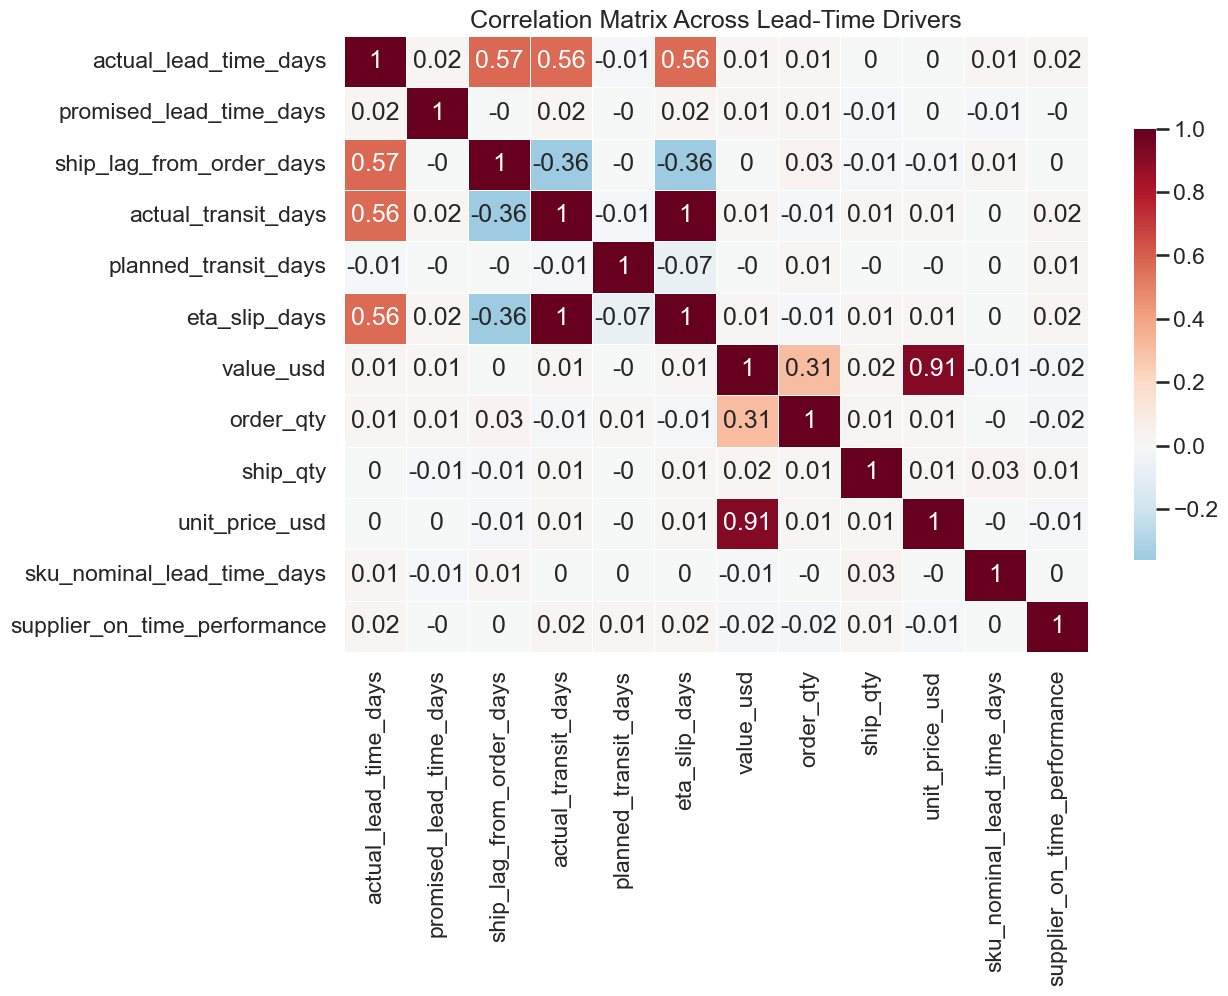

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    ax=ax,
)
ax.set_title("Correlation Matrix Across Lead-Time Drivers")
plt.show()


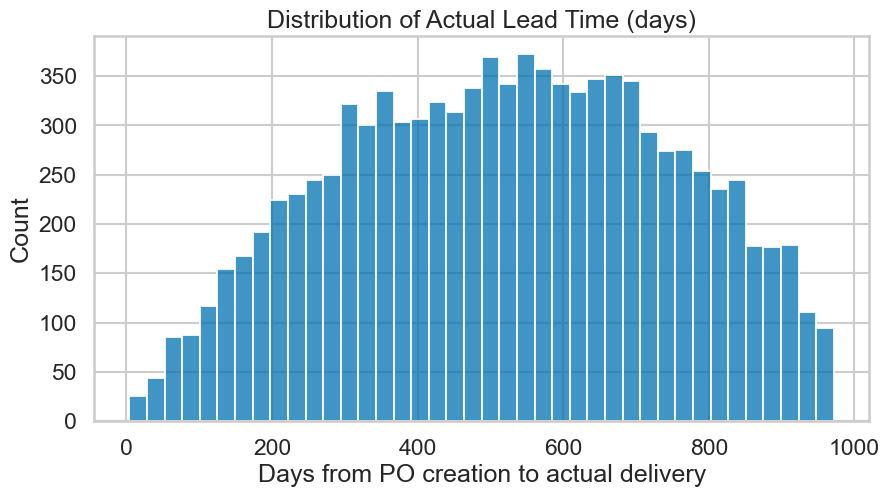

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(model_df["actual_lead_time_days"], bins=40, ax=ax, color="#0072B2")
ax.set_title("Distribution of Actual Lead Time (days)")
ax.set_xlabel("Days from PO creation to actual delivery")
plt.show()


In [51]:
numeric_features = [
    "order_qty",
    "unit_price_usd",
    "value_usd",
    "ship_qty",
    "promised_lead_time_days",
    "ship_lag_from_order_days",
    "planned_transit_days",
    "eta_slip_days",
    "sku_nominal_lead_time_days",
    "supplier_on_time_performance",
]

categorical_features = [
    "region",
    "country",
    "status_po",
    "status_ship",
    "mode",
    "incoterm",
    "origin_country",
    "dest_region",
    "dest_country",
    "dest_site_type",
    "supplier_region",
    "supplier_country",
    "supplier_primary_vendor",
    "sku_category",
    "sku_technology",
]

target = "actual_lead_time_days"
feature_cols = numeric_features + categorical_features

X = model_df[feature_cols]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

candidate_models = {
    "hist_gradient_boosting": HistGradientBoostingRegressor(
        learning_rate=0.08,
        max_depth=8,
        max_iter=400,
        random_state=42,
    ),
    "random_forest": RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42,
    ),
}

def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse_scorer = make_scorer(
    root_mean_squared_error,
    greater_is_better=False,
)

cv_results = []
for name, estimator in candidate_models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("regressor", estimator),
        ]
    )
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring={
            "mae": "neg_mean_absolute_error",
            "rmse": rmse_scorer,
            "r2": "r2",
        },
        n_jobs=-1,
    )
    cv_results.append(
        {
            "model": name,
            "cv_mae": -scores["test_mae"].mean(),
            "cv_rmse": -scores["test_rmse"].mean(),
            "cv_r2": scores["test_r2"].mean(),
        }
    )

cv_results = pd.DataFrame(cv_results).sort_values("cv_mae").reset_index(drop=True)
print("5-fold CV summary:")
print(cv_results)

best_model_name = cv_results.loc[0, "model"]
best_regressor = candidate_models[best_model_name]
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", best_regressor),
    ]
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nSelected model: {best_model_name}")
print(f"MAE: {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R^2: {r2:.3f}")

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
model_artifact = models_dir / f"lead_time_{best_model_name}.joblib"
joblib.dump(model, model_artifact)
print(f"Saved trained pipeline to {model_artifact}")


5-fold CV summary:
                    model    cv_mae    cv_rmse     cv_r2
0  hist_gradient_boosting  5.228850   7.056409  0.999012
1           random_forest  8.326311  10.664207  0.997749

Selected model: hist_gradient_boosting
MAE: 4.78 days
RMSE: 6.50 days
R^2: 0.999
Saved trained pipeline to models\lead_time_hist_gradient_boosting.joblib


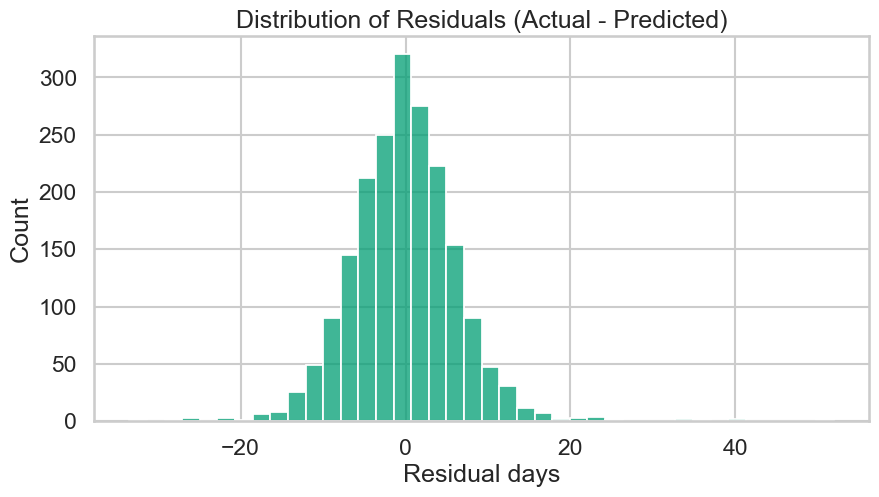

In [52]:
eval_df = X_test.copy()
eval_df = eval_df.assign(
    actual=y_test.values,
    predicted=y_pred,
)
eval_df["residual"] = eval_df["actual"] - eval_df["predicted"]

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(eval_df["residual"], bins=40, color="#009E73", ax=ax)
ax.set_title("Distribution of Residuals (Actual - Predicted)")
ax.set_xlabel("Residual days")
plt.show()


C:\Users\miskibin\AppData\Local\Temp\ipykernel_3484\2288916159.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eval_df, x="mode", y="residual", order=order, palette="Set2", ax=ax)


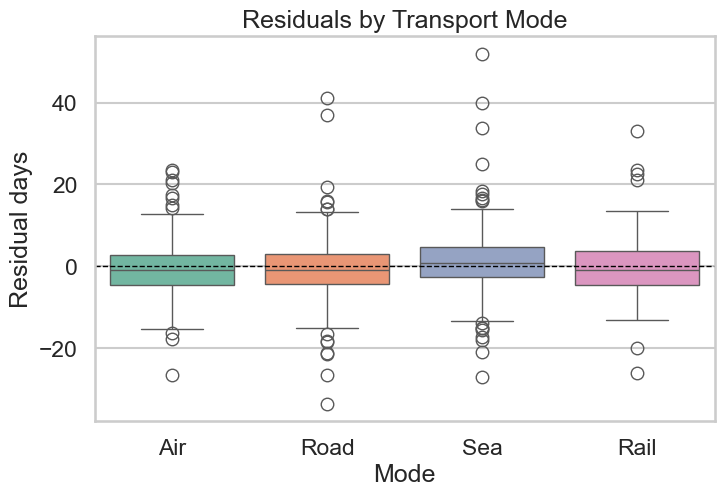

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))
order = ["Air", "Road", "Sea", "Rail"]
sns.boxplot(data=eval_df, x="mode", y="residual", order=order, palette="Set2", ax=ax)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_title("Residuals by Transport Mode")
ax.set_xlabel("Mode")
ax.set_ylabel("Residual days")
plt.show()


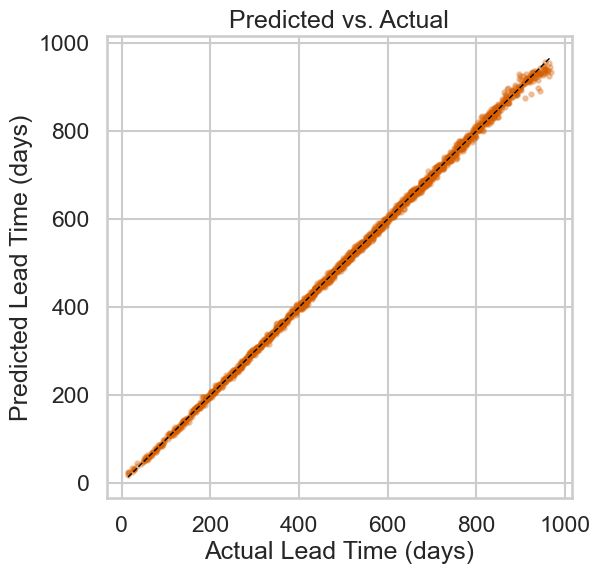

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_pred, alpha=0.3, s=10, color="#D55E00")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Actual Lead Time (days)")
ax.set_ylabel("Predicted Lead Time (days)")
ax.set_title("Predicted vs. Actual")
plt.show()


In [55]:
perm_importance = permutation_importance(
    model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
)
feature_importance = (
    pd.DataFrame(
        {
            "feature": feature_cols,
            "importance": perm_importance.importances_mean,
            "std": perm_importance.importances_std,
        }
    )
    .sort_values("importance", ascending=False)
    .head(15)
)
feature_importance


,feature,importance,std
5,ship_lag_from_order_days,1.414437e+00,2.418351e-02
7,eta_slip_days,1.312836e+00,3.722723e-02
6,planned_transit_days,5.530525e-03,1.093995e-04
9,supplier_on_time_performance,6.000744e-06,2.016163e-06
14,mode,5.872621e-06,1.011489e-06
16,origin_country,5.729494e-06,3.052671e-06
1,unit_price_usd,3.833757e-06,4.688146e-06
8,sku_nominal_lead_time_days,3.533566e-06,4.993209e-06
22,supplier_primary_vendor,1.565787e-06,1.896460e-06
2,value_usd,1.450270e-06,4.662586e-06


In [56]:
def predict_po_lead_time(sample_inputs):
    df = pd.DataFrame(sample_inputs)
    df["order_date"] = pd.to_datetime(df["order_date"])
    df["promised_date"] = pd.to_datetime(df["promised_date"])
    df["promised_lead_time_days"] = (df["promised_date"] - df["order_date"]).dt.days
    df["value_usd"] = df["order_qty"] * df["unit_price_usd"]

    df = df.merge(supplier_cols, on="supplier_id", how="left")
    df = df.merge(sku_cols, on="sku_id", how="left")

    default_values = {
        "ship_qty": np.nan,
        "ship_lag_from_order_days": np.nan,
        "planned_transit_days": np.nan,
        "eta_slip_days": np.nan,
        "status_po": "Open",
        "status_ship": np.nan,
        "mode": np.nan,
        "incoterm": np.nan,
        "origin_country": np.nan,
        "dest_region": np.nan,
        "dest_country": np.nan,
        "dest_site_type": np.nan,
    }
    for col, value in default_values.items():
        if col not in df.columns:
            df[col] = value

    for col in feature_cols:
        if col not in df.columns:
            df[col] = np.nan

    predictions = model.predict(df[feature_cols])
    result = df[
        [
            "supplier_id",
            "sku_id",
            "order_qty",
            "unit_price_usd",
            "order_date",
            "promised_date",
            "region",
            "country",
        ]
    ].copy()
    result["predicted_lead_time_days"] = predictions
    return result

example_pos = [
    {
        "supplier_id": "S-0161",
        "sku_id": "SKU-02137",
        "order_qty": 14,
        "unit_price_usd": 305.99,
        "order_date": "2024-02-17",
        "promised_date": "2024-03-15",
        "region": "EMEA",
        "country": "France",
    },
    {
        "supplier_id": "S-0043",
        "sku_id": "SKU-04868",
        "order_qty": 6,
        "unit_price_usd": 197.63,
        "order_date": "2024-12-31",
        "promised_date": "2025-01-23",
        "region": "EMEA",
        "country": "United Kingdom",
    },
]

predict_po_lead_time(example_pos)


,supplier_id,sku_id,order_qty,unit_price_usd,order_date,promised_date,region,country,predicted_lead_time_days
0,S-0161,SKU-02137,14,305.99,2024-02-17,2024-03-15,EMEA,France,421.625269
1,S-0043,SKU-04868,6,197.63,2024-12-31,2025-01-23,EMEA,United Kingdom,420.484787


In [ ]:
mode_summary = (
    model_df.groupby("mode")["actual_lead_time_days"]
    .agg(["median", "mean", "count"])
    .sort_values("median", ascending=False)
)

incoterm_summary = (
    model_df.groupby("incoterm")["actual_lead_time_days"]
    .agg(["median", "mean", "count"])
    .sort_values("median", ascending=False)
)

supplier_delta = (
    model_df.groupby("supplier_id")
    .agg(
        shipments=("shipment_id", "count"),
        avg_value=("value_usd", "mean"),
        actual_lead=("actual_lead_time_days", "mean"),
        promised_lead=("promised_lead_time_days", "mean"),
    )
    .assign(avg_overrun=lambda df: df["actual_lead"] - df["promised_lead"])
    .sort_values("avg_overrun", ascending=False)
)

mode_summary, incoterm_summary, supplier_delta.head(10)


(      median        mean  count
 mode                           
 Air    533.0  524.576970   2449
 Road   525.0  518.233910   2890
 Sea    524.0  516.979795   3514
 Rail   521.0  525.403866    983,
           median        mean  count
 incoterm                           
 EXW        535.0  522.791667   1464
 DDP        534.0  526.038127   1495
 DAP        533.0  522.304523   2476
 FOB        521.0  519.972350   2387
 CIF        511.0  511.087388   2014,
              shipments    avg_value  actual_lead  promised_lead  avg_overrun
 supplier_id                                                                 
 S-0057              42  6657.008810   599.452381      29.404762   570.047619
 S-0079              40  4694.236750   593.800000      27.525000   566.275000
 S-0112              41  6690.863659   583.634146      27.853659   555.780488
 S-0094              49  5177.450408   584.469388      29.530612   554.938776
 S-0039              43  5760.765349   581.697674      31.093023   550.60

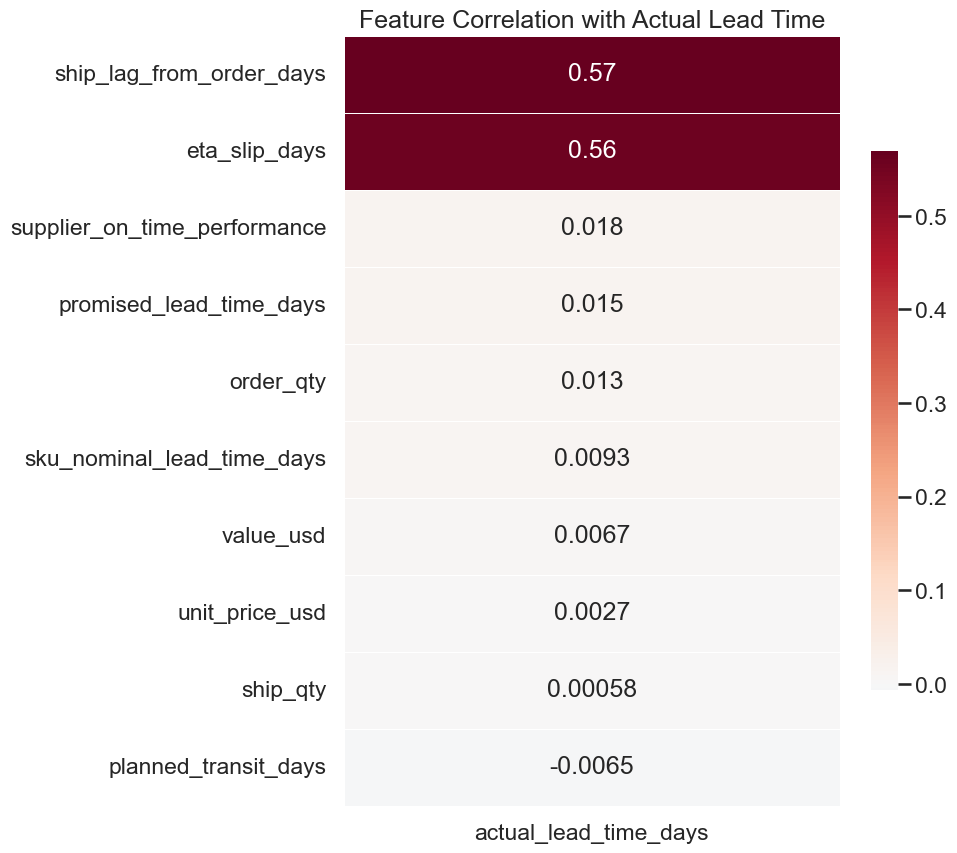

In [ ]:
# heat map of what features contribute most to lead time
# Only numeric columns can be used for Pearson correlation — exclude categorical string columns.
cols = feature_cols + [target]
numeric_df = model_df[cols].select_dtypes(include=[np.number])

if numeric_df.shape[1] <= 1:
    print("No numeric features available for correlation plot.")
else:
    feature_corr = numeric_df.corr()[target].drop(target)
    feature_corr = feature_corr.sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(
        feature_corr.to_frame(),
        annot=True,
        cmap="RdBu_r",
        center=0,
        linewidths=0.5,
        cbar_kws={"shrink": 0.7},
        ax=ax,
    )
    ax.set_title("Feature Correlation with Actual Lead Time")
    plt.show()

### Note

Values: `ship_lag_from_order_days` and `eta_slip_days` sit around 0.56–0.57 because real lead time literally includes how long it took to ship and how far the ETA slipped, so those timelines move together. `supplier_on_time_performance`, `promised_lead_time_days`, and `order_qty` barely correlate because (a) the promised window barely varies and is often wildly wrong compared to reality, (b) supplier performance is a coarse historical average that doesn’t capture a specific PO, and (c) order quantity doesn’t systematically affect transit duration in this dataset.